In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

import torch.optim as optim
import torch
import torch.nn as nn

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display,clear_output

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from dataset import HelocDataset
from experiments import Benchmarking
from utils.logger_config import setup_logger
from tqdm import tqdm
from models.wrapper import PYTORCH_MODELS

logger = setup_logger()

In [ ]:
from dataset import dataset_loader

In [ ]:
name = 'heloc'
dataset_ares = dataset_loader(name, data_path='data/', dropped_features=[], n_bins=None)

In [ ]:
from experiments.counterfactual import *
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from models import PyTorchDNN, PyTorchLinearSVM, PyTorchRBFNet, PyTorchLogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.gaussian_process import GaussianProcessClassifier

In [ ]:
dataset = HelocDataset(dataset_ares=dataset_ares)

input_dim = dataset.get_dataframe().shape[1] - 1
seed = None
# torch.manual_seed(seed)

counterfactual_algorithms = [
    # 'DiCE',
    # 'DisCount',
    # 'GlobeCE',
    # 'AReS',
    'KNN',
]

experiment = Benchmarking(
    dataset=dataset,
    models=[
        # (GaussianProcessClassifier(),'sklearn'),
        # (PyTorchLogisticRegression(input_dim=input_dim), 'PYT'),
        (PyTorchDNN(input_dim=input_dim), 'PYT'),
        # (PyTorchRBFNet(input_dim=input_dim, hidden_dim=input_dim), 'PYT'),
        # (PyTorchLinearSVM(input_dim=input_dim), 'PYT'),
        # (RandomForestClassifier(n_estimators=10), 'sklearn'), 
        # (GradientBoostingClassifier(n_estimators=10), 'sklearn'), 
        # (AdaBoostClassifier(n_estimators=10), 'sklearn'), 
    ],
    shapley_methods=[
        # "Train_Distri",
        "CF_UniformMatch",
        # "CF_ExactMatch",
        "CF_SingleMatch",
        # "CF_OTMatch",
        "CF_OTMatch_2.0", 
        # "CF_OTMatch_50.0",
        # "CF_OTMatch_100.0",
        # "CF_OTMatch_10.0",
    ],
    distance_metrics=[
        'optimal_transport',
        'mean_difference',
        'median_difference',
        # 'max_mean_discrepancy',
    ]
)

experiment.train_and_evaluate_models(random_state=seed)
experiment.models_performance()

logger.info("\n\n------Compute Counterfactuals------")
sample_num = 50
model_counterfactuals = {}
for model, model_name in zip(experiment.models, experiment.model_names):
    model_counterfactuals[model_name] = {}

    for algorithm in counterfactual_algorithms:
        if algorithm == 'DisCount' and model_name not in PYTORCH_MODELS:
            logger.info(f'Skipping {algorithm} for {model_name} due to incompatability')
            continue
        logger.info(f'Computing {model_name} counterfactuals with {algorithm}')
        function_name = f"compute_{algorithm}_counterfactuals"
        try:
            func = globals()[function_name]
            model_counterfactuals[model_name][algorithm] = func(
                experiment.X_test,
                model = model,
                target_name = experiment.dataset.target_name,
                sample_num = sample_num,
                experiment=experiment,
            )
        except KeyError:
            print(f"Function {function_name} is not defined.")

In [ ]:
logger.info("\n\n------Compute Shapley Values------")
experiment.compute_shapley_values(
    model_counterfactuals=model_counterfactuals,
);

In [ ]:
logger.info("\n\n------Evaluating Distance Performance Under Interventions------")
experiment.evaluate_distance_performance_under_interventions(
    intervention_num_list=[0, 50, 100, 150, 200, 300, 400, 600],
    trials_num=100,
    replace=False,
)

In [ ]:
from experiments import plotting

plotting.intervention_vs_distance(experiment, save_to_file=False)

In [ ]:
# X_factual = model_counterfactuals['PyTorchDNN']['KNN']['X_factual']
# X_counterfactual = model_counterfactuals['PyTorchDNN']['KNN']['X']

# X_baseline = X_counterfactual

# import ot
# N = X_factual.shape[0]
# reg = 0.1

# ot_cost = ot.dist(X_factual, X_counterfactual, p=2)
# # ot_plan = ot.bregman.sinkhorn(
# #     np.ones(N) / N, np.ones(N) / N, ot_cost, reg=reg, numItermax=5000
# # )
# ot_plan = ot.emd(np.ones(N) / N, np.ones(N) / N, ot_cost)

# weights = ot_plan[0]
# weights = weights + 1e-20
# weights = weights / (weights.sum())

# indice = np.random.choice(X_baseline.shape[0], p=weights, replace=True, size=1000)
# np.unique(indice), np.unique(indice).shape

In [205]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
from itertools import chain, combinations
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


In [206]:
# Function to generate the power set of features
def powerset(iterable):
    s = list(iterable)
    return list(chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))

# Define f(z_i) as the prediction from a trained model
def f(model, z_i):
    return model.predict(z_i.reshape(1, -1))[0]

# Create a toy dataset
np.random.seed(0)
n = 3  # Number of data points
p = 3  # Number of features

# Original dataset x (nxp)
x = np.random.rand(n, p)

# Target dataset r (nxp)
r = np.random.rand(n, p)

# Target values y for the original dataset
y = np.random.rand(n)

# Train a machine learning model (linear regression) on the original dataset
model = LinearRegression()
model.fit(x, y)

LinearRegression()

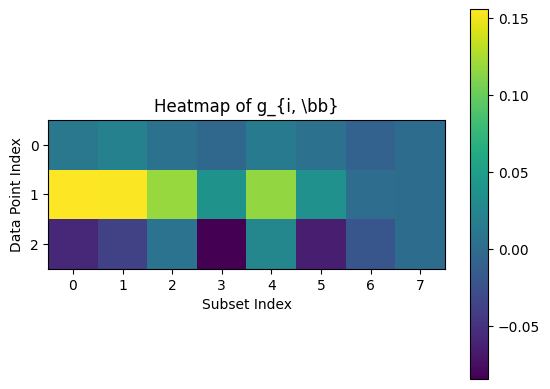

In [207]:
# Generate the power set and create a mapping
feature_indices = range(p)
subsets = powerset(feature_indices)
num_subsets = len(subsets)

# Compute sizes of each subset
s = [len(subset) for subset in subsets]

# Compute g_{i, \bb} for each data point and each subset
g = np.zeros((n, num_subsets))

for i in range(n):
    r_i = r[i]
    f_r_i = f(model, r_i)
    for j, subset in enumerate(subsets):
        z_i = x[i].copy()  # Start with the original row
        for k in subset:
            z_i[k] = r[i][k]  # Replace values in subset with values from r_i
        f_z_i = f(model, z_i)
        g[i, j] = f_z_i - f_r_i  # Compute g_{i, \bb}

g /= n

# Visualize the matrix g using a heatmap
plt.imshow(g, cmap='viridis')
plt.colorbar()
plt.xlabel('Subset Index')
plt.ylabel('Data Point Index')
plt.title('Heatmap of g_{i, \\bb}')
plt.show()

In [208]:
C = 2

# Create the model
problem = gp.Model('subset_selection')

# Decision variables
a = problem.addVars(n, num_subsets, vtype=GRB.BINARY, name="a")

# Variable for the objective
eta = problem.addVar(vtype=GRB.CONTINUOUS, name="eta")

# Objective function
problem.setObjective(eta, GRB.MINIMIZE)

# Constraints
# Absolute value constraint
problem.addConstr(gp.quicksum(g[i, j] * a[i, j] for i in range(n) for j in range(num_subsets)) <= eta, "abs_pos")
problem.addConstr(gp.quicksum(g[i, j] * a[i, j] for i in range(n) for j in range(num_subsets)) >= -eta, "abs_neg")

# Coverage constraint: Ensure at least one subset is selected for each data point
problem.addConstrs((gp.quicksum(a[i, j] for j in range(num_subsets)) == 1 for i in range(n)), "coverage")

# Capacity constraint: Ensure the total size of selected subsets does not exceed C across all data points
problem.addConstr(gp.quicksum(s[j] * a[i, j] for i in range(n) for j in range(num_subsets)) <= C, "capacity")


# Optimize the model
problem.optimize()

# Print the results
for v in problem.getVars():
    if v.varName != "eta" and v.x > 0.001:  # Only print the variables that are part of the solution
        var_name_parts = v.varName.split('[')[1].rstrip(']').split(',')
        i = int(var_name_parts[0])
        j = int(var_name_parts[1])
        subset = subsets[j]
        print(f"Data point {i} uses subset {subset}")

print(f"Objective Value (eta): {eta.X}")

# Calculate the value of the constraint expression
total_size = sum(s[j] * a[i, j].X for i in range(n) for j in range(num_subsets))
total_size

print(f"Total size = {total_size}")

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]


INFO:gurobipy:CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 6 rows, 25 columns and 89 nonzeros


INFO:gurobipy:Optimize a model with 6 rows, 25 columns and 89 nonzeros


Model fingerprint: 0xa3fabeeb


INFO:gurobipy:Model fingerprint: 0xa3fabeeb


Variable types: 1 continuous, 24 integer (24 binary)


INFO:gurobipy:Variable types: 1 continuous, 24 integer (24 binary)


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 3e+00]


INFO:gurobipy:  Matrix range     [1e-03, 3e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 2e+00]


INFO:gurobipy:  RHS range        [1e+00, 2e+00]


Found heuristic solution: objective 0.0880172


INFO:gurobipy:Found heuristic solution: objective 0.0880172


Presolve removed 0 rows and 10 columns


INFO:gurobipy:Presolve removed 0 rows and 10 columns


Presolve time: 0.00s


INFO:gurobipy:Presolve time: 0.00s


Presolved: 6 rows, 15 columns, 49 nonzeros


INFO:gurobipy:Presolved: 6 rows, 15 columns, 49 nonzeros


Variable types: 1 continuous, 14 integer (14 binary)


INFO:gurobipy:Variable types: 1 continuous, 14 integer (14 binary)


INFO:gurobipy:


Root relaxation: objective 0.000000e+00, 7 iterations, 0.00 seconds (0.00 work units)


INFO:gurobipy:Root relaxation: objective 0.000000e+00, 7 iterations, 0.00 seconds (0.00 work units)


INFO:gurobipy:


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


     0     0    0.00000    0    4    0.08802    0.00000   100%     -    0s


INFO:gurobipy:     0     0    0.00000    0    4    0.08802    0.00000   100%     -    0s


H    0     0                       0.0455507    0.00000   100%     -    0s


INFO:gurobipy:H    0     0                       0.0455507    0.00000   100%     -    0s


H    0     0                       0.0083483    0.00000   100%     -    0s


INFO:gurobipy:H    0     0                       0.0083483    0.00000   100%     -    0s


H    0     0                       0.0011716    0.00000   100%     -    0s


INFO:gurobipy:H    0     0                       0.0011716    0.00000   100%     -    0s


INFO:gurobipy:


Explored 1 nodes (7 simplex iterations) in 0.07 seconds (0.00 work units)


INFO:gurobipy:Explored 1 nodes (7 simplex iterations) in 0.07 seconds (0.00 work units)


Thread count was 8 (of 8 available processors)


INFO:gurobipy:Thread count was 8 (of 8 available processors)


INFO:gurobipy:


Solution count 4: 0.00117158 0.00834833 0.0455507 0.0880172 


INFO:gurobipy:Solution count 4: 0.00117158 0.00834833 0.0455507 0.0880172 


INFO:gurobipy:


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Best objective 1.171576088666e-03, best bound 1.171576088666e-03, gap 0.0000%


INFO:gurobipy:Best objective 1.171576088666e-03, best bound 1.171576088666e-03, gap 0.0000%


Data point 0 uses subset (0,)
Data point 1 uses subset (2,)
Data point 2 uses subset ()
Objective Value (eta): 0.0011715760886662485
Total size = 2.0


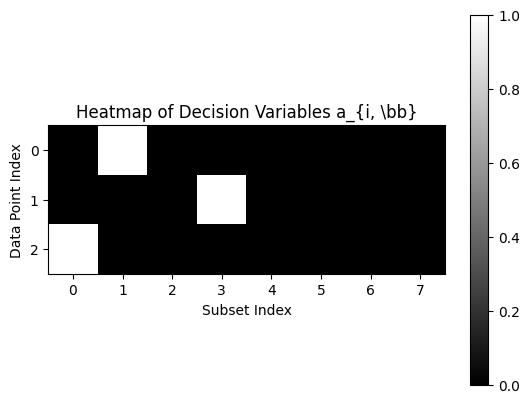

In [209]:
s# Extract the solution for the decision variables a
a_solution = np.zeros((n, num_subsets))

for i in range(n):
    for j in range(num_subsets):
        if a[i, j].X > 0.5:  # Gurobi returns the value of the variable, check if it's selected
            a_solution[i, j] = 1

# Visualize the matrix a_solution using a heatmap
plt.imshow(a_solution, cmap='gray',)
plt.colorbar()
plt.xlabel('Subset Index')
plt.ylabel('Data Point Index')
plt.title('Heatmap of Decision Variables a_{i, \\bb}')
plt.show()